# JAX Basics

In [ ]:
import jax
from jax import numpy as jnp
import numpy as np


# cool feature no. 1

x = np.array([1.0, 2.0])[None].T
y = jnp.array([1.0, 2.0])[None].T

# numpy arrays are transformed to JAX tensors automatically at operation execution (no to_tensor, from_numpy mumbo-jumbo)
print("Dot product:", x.T@y)

In [ ]:
# jax arrays are immutable

#y[0] = 3.0
y.at[0].set(3.0)

In [ ]:
# we can do this, by the following syntax (first uglyness)

y.at[0].set(1.0) # returns a new array

# The JIT

Stands for "Just in Time Compilation"

In [ ]:

M = np.random.uniform(-0.1, 0.1, (500, 500))
M_jax = jnp.array(M)

def numpy_function(M):
    return M @ M.T

def function(M):
    return M @ M.T

@jax.jit
def jit_function(M):
    return  M @ M.T

In [ ]:
print("Numpy function:")
%timeit  numpy_function(M)
print("JAX function:")
%timeit  function(M_jax)
print("JAX jit function:")
%timeit  jit_function(M_jax)

## Calculating Gradients

Using the `jax.grad` function

In [ ]:
import functools
from matplotlib import pyplot as plt
# n-th order polynomial

n = 6
roots = np.random.uniform(-3, 3, n).astype(np.float64)
def nth_order_polynomial(x, roots):
    y = 1
    for r in roots:
        y = y*(x-r)
    return y


poly = jax.jit(functools.partial(nth_order_polynomial, roots=roots))

x = jnp.linspace(-2, 2, 100)

y = poly(x)


plt.plot(x, y)

In [ ]:
# we can trace the computation of the polynomial
jax.make_jaxpr(poly)(2)

In [ ]:
# n-th order derivatives of this function?
grad_func = poly
nth_order_grads = []
for i in range(n):

    grad_func = jax.grad(grad_func)
    y = jax.vmap(grad_func)(x)
    plt.plot(x, y, label=f'n={i+1}')
plt.legend()

# JAX Can Differentiate with Respect to (almost) Anything

As long as we register the type. But standard Python containers are supported out of the box.






In [ ]:



def square(data):
    return data['x']**2 + data['y']**2

g = jax.grad(square)({"x": 1.0, "y": 2.0})

print(f"Gradient 1: {g}")


def square(data):
    return data[0]**2 + data[1] ** 2

g = jax.grad(square)([1.0, 2.0])
print(f"Gradient 2: {g}")


from dataclasses import dataclass
@dataclass
class Point:
    x: float
    y: float

from jax.tree_util import register_pytree_node

register_pytree_node(
    Point, 
    lambda x: ([x.x, x.y], None), #unpacking
    lambda d, x: Point(*x)
)

def square(data):
    return data.x**2 + data.y ** 2

g = jax.grad(square)(Point(1.0, 2.0))
print(f"Gradient 3: {g}")



# Basic ML

In [ ]:
# dataset for linear regression


def generate_data(d, N):
    x = np.random.uniform(-1,1, (N, d))
    theta = np.random.uniform(-1,1, (d,1))
    y = x @ theta
    theta_ = np.random.uniform(-1,1, (d,1))
    return x, y, theta, theta_

x, y, theta, theta_ = generate_data(20, 500)



def vis_lines(theta, theta_):
    x = np.linspace(-2, 2, 100)
    y = theta[0, 0]*x + theta[1,0]
    y_ = theta_[0,0]*x+ theta_[1,0]
    plt.plot(x, y, label='gt')
    plt.plot(x, y_, label='pred')
    plt.legend()



In [ ]:
@jax.jit
def predict(x, theta):
    return x@theta

def mse(x, theta, y):
    y_ = predict(x, theta)
    return ((y-y_)**2).mean()

grad_func = jax.grad(mse, argnums=[1]) # returns a function which takes the same arguments as the wrapped one


# returns tuple of gradients with respect to arguments of function
grad, = grad_func(x, theta, y)

# for practicality, this is also available
loss, (grad,) = jax.value_and_grad(mse, argnums=[1])(x,theta_, y)
print(f"MSE loss: {loss}")



vis_lines(theta, theta_)

In [ ]:
# stupid loop to optimize our model
for _ in range(50):
    loss, (grad,) = jax.value_and_grad(mse, argnums=[1])(x,theta_, y)
    theta_ -= 0.01*grad 

print(f"MSE: {loss}")
vis_lines(theta, theta_)

In [ ]:
# what if we want to get a Jacobian?
J, = jax.jacobian(predict, argnums=[0])(x[0], theta)
J.shape

In [ ]:
# what about the Hessian?
H, = jax.jacfwd(jax.jacrev(predict), argnums=[0])(x[0], theta)
H.shape

# 2nd Order Optimization!

In [ ]:
from matplotlib import pyplot as plt
d = 10

@jax.jit
def square(x):
    return (x**2).sum(-1)


x = np.linspace(-10, 10, 100)[:, None]
plt.plot(x, square(x))



In [ ]:
x0 = jnp.array([10.0]*d)
# how does the hessian look like?
jax.hessian(square)(x0)

In [ ]:
# lets try to minimize it via gradient descent

f = square
x_ = x0
trajx = []
trajy = []

err = 1e-3
for i in range(200):
    g = jax.grad(f)(x_)
    x_ -= 0.01*g
    trajx.append(x_[0])
    trajy.append(f(x_))
    if trajy[-1] < err:
        break
print(f"Converged in {i} steps, {err}, {x_}")
plt.plot(x, f(x))
plt.plot(trajx, trajy)

In [ ]:
# lets try to minimize it via gradient descent

f = square
x_ = x0
trajx = [x0[0]]
trajy = [f(x0)]
f = square



err = 1e-6
for i in range(100):
    g = jax.grad(f)(x_)[:, None]
    H = jax.hessian(f)(x_)
    x_ -= (jnp.linalg.inv(H) @ g).flatten()
    trajx.append(x_[0])
    trajy.append(f(x_))
    if trajy[-1] < err:
        break
print(f"Converged in {i} steps, {err}, {x_}")
plt.plot(x, f(x))
plt.plot(trajx, trajy)
plt.scatter(trajx, trajy, color='red')

# Vectorization / Parallelization

In [ ]:
# vmap usage
# say we have a "complicated function" that we want to apply row-wise, ie. over axis=0

M = np.random.uniform(1, 10, (200, 2))
func = lambda x: x[0]**2 + jnp.exp(x[1])

@jax.jit
def naive(M):
    return jnp.stack([func(x) for x in M])

@jax.jit
def with_vmap(M):
    return jax.vmap(func)(M)


@jax.jit
def with_pmap(M): # this is just for the sake of example, it goes across devices
    return jax.pmap(func)(M)


print("Naive:")
%timeit -n 50 naive(M)
print("With vmap:")
%timeit -n 50 with_vmap(M)

# Note on Gradient Calculation

<p style="font-size:20px">

Some options:
* finite differences $\frac{df}{dx} = \lim_{h \mapsto 0} \frac{f(x+h)-f(x)}{h}$
* symbolic
* automatic differentiation - most of deep learning
<p>


In [ ]:
@jax.jit
def square(x):
    return x**2

def finite_differences(f, h):
    def func(x):
        return  (f(x+h)-f(x))/h
    return func


finite_differences(square, 1e-5)(2.0)

# Autodiff Forward vs. Reverse Mode

<p style="font-size:16px">

**Forward Mode**: augments the outputs of the forward pass with their derivatives in a (primal, tangent) tuple $(x, \dot x)$. This is preferred in the case where the number of inputs is much smaller than the number of outputs, in practice we compute a Jacobian-vector product.


**Reverse Mode**: comes in two stages. First we make a forward pass through our computation graph which is followed by computation of partial derivatives with respect to intermediate variables (adjoints). Backpropagation is a special case of reverse mode autodiff. Vector-Jacobian product.

**Reverse on Forward**: hybrid, for example computing Hessian.

</p>

In [ ]:
# back to our Hessian example, let's time it with different ways of computing the gradient
print("Only reverse mode autodiff:")
%timeit jax.jacrev(jax.jacrev(predict), argnums=[0])(x[0], theta)
print("Hybrid autodiff:")
%timeit jax.jacrev(jax.jacfwd(predict), argnums=[0])(x[0], theta)


# JAX Random Numbers

Random numbers in JAX are annoying. There is no stateful random number generator, but we need to pass around a `key` that we split with `jax.random.split`. This is also where JAX syntax for distributions and numpy syntax differs considerably.

In [ ]:
random_seed = 123
key = jax.random.PRNGKey(random_seed) 

rngs = jax.random.split(key, 10)


print("These are 10 random numbers")
print(jnp.array([jax.random.normal(k) for k in rngs]))
print("These are the same numbers")
print(jnp.array([jax.random.normal(k) for k in rngs]))


# Here come the neural networks...

In [ ]:
# say we use an ensemble neural network (this cause a bit of pain for me and Sebastian to implement in PyTorch)
from jax.tree_util import tree_flatten, tree_unflatten



def tree_stack(trees):
    """Takes a list of trees and stacks every corresponding leaf.
    For example, given two trees ((a, b), c) and ((a', b'), c'), returns
    ((stack(a, a'), stack(b, b')), stack(c, c')).
    Useful for turning a list of objects into something you can feed to a
    vmapped function.
    """
    leaves_list = []
    treedef_list = []
    for tree in trees:
        leaves, treedef = tree_flatten(tree)
        leaves_list.append(leaves)
        treedef_list.append(treedef)

    grouped_leaves = zip(*leaves_list)
    result_leaves = [jnp.stack(l) for l in grouped_leaves]
    return treedef_list[0].unflatten(result_leaves)


def tree_unstack(tree):
    """Takes a tree and turns it into a list of trees. Inverse of tree_stack.
    For example, given a tree ((a, b), c), where a, b, and c all have first
    dimension k, will make k trees
    [((a[0], b[0]), c[0]), ..., ((a[k], b[k]), c[k])]
    Useful for turning the output of a vmapped function into normal objects.
    """
    leaves, treedef = tree_flatten(tree)
    n_trees = leaves[0].shape[0]
    new_leaves = [[] for _ in range(n_trees)]
    for leaf in leaves:
        for i in range(n_trees):
            new_leaves[i].append(leaf[i])
    new_trees = [treedef.unflatten(l) for l in new_leaves]
    return new_trees



def get_nn_params():
        return [
            (np.random.uniform(-1,1, (10, 512)), np.random.uniform(-1,1, (512, 1))),
            (np.random.uniform(-1,1, (512, 256)), np.random.uniform(-1,1, (256, 1))),
            (np.random.uniform(-1,1, (256, 2)),  np.random.uniform(-1,1, (2,1)))
        ]


@jax.jit
def forward(x, theta):
    for w, b in theta:
        x = jax.nn.relu(x@w) + b.T
    return x



params = get_nn_params()


out = forward(x, params)
out.shape



In [ ]:
lots_of_params = [get_nn_params() for _ in range(20)]
# how do we parallelize this?

stacked_tree = tree_stack(lots_of_params)

def seq_ensemble_forward(x, trees):
    return jnp.stack([forward(x,tree) for tree in trees])


seq_ensemble_forward = jax.jit(seq_ensemble_forward)

vmap_ensemble_forward = jax.vmap(forward, in_axes=[None,[(0, 0)]*len(lots_of_params[0])])
vmap_ensemble_forward = jax.jit(vmap_ensemble_forward)



# seems to still not be better than linear speedup when stacking the matrices into tensors, but there is some improvement (possibly limited by hardware)

In [ ]:
# what about simple stacking?

@jax.jit
def stacked_forward(x, theta):
    for w, b in theta:
        x = jax.nn.relu(x@w) + b.transpose(0,2,1)
    return x


In [ ]:

x = np.random.uniform(-1,1, (1024,10))

vmap_ensemble_forward(x, stacked_tree)
stacked_forward(x, stacked_tree)
seq_ensemble_forward(x, lots_of_params)

%timeit stacked_forward(x, stacked_tree).block_until_ready() 


%timeit vmap_ensemble_forward(x, stacked_tree).block_until_ready() 


%timeit seq_ensemble_forward(x, lots_of_params).block_until_ready() 





In [ ]:
# JAX magic functions

# dataset
x = np.random.uniform(-1,1, (100, 10))
theta = np.random.uniform(-1,1, (10,1))
theta_ = np.random.uniform(-1,1, (10,1))




y = x @ theta # ground truth
y_ = x @ theta_ # estimates

# mse error
def mse(y_,y):
    pass
    





In [ ]:
# numpy and JAX syntax is similar in most cases, except one crucial annoying one...

# random seed initialization
random_seed = 123
key = jax.random.PRNGKey(random_seed) # returns 

# Flax: Making Things More Simple

Alternatives: Haiku, Stax, Objax

In [ ]:
import flax
import jax
from jax import numpy as jnp
import numpy as np
from typing import Optional
# for details about this, read about python >=3.7 dataclasses

class MLP(flax.linen.Module):
    # here, ordering is preserved
    num_hidden: int
    hidden_size: int
    outputs: int
    act_function: Optional[str] = 'relu'

    def setup(self):
        self.layers = [flax.linen.Dense(features=64) for _ in range(self.num_hidden)]
        self.last_layer = flax.linen.Dense(self.outputs)

    def __call__(self, x):
        act_function = getattr(flax.linen, self.act_function)
        for layer in self.layers[:-1]:
            x = act_function(layer(x))
        # don't apply act in last layer
        x = self.layers[-1](x)
        return x


key = jax.random.PRNGKey(0)

X = np.random.randn(128, 10)

model = MLP(2, 64, 2)

# we need to call the init function, takes a batch and key
key, _ = jax.random.split(key)
params = model.init(key, X)


# we need to call the apply function for the forward pass, which also takes the model parameters
y_ = model.apply(params, X)
y_.shape

In [33]:
import flax
from typing import Optional
# for details about this, read about python 3.7 datamodule class

class MLPCompact(flax.linen.Module):
    # here, ordering is preserved
    num_hidden: int
    hidden_size: int
    outputs: int
    act_function: Optional[str] = 'relu'
    
    @flax.linen.compact
    def __call__(self, x):
        act_function = getattr(flax.linen, self.act_function)
        for _ in range(self.num_hidden):
            x = flax.linen.Dense(self.hidden_size)(x)
            x = act_function(x)
        # don't apply act in last layer
        x = flax.linen.Dense(self.outputs)(x)
        return x


key = jax.random.PRNGKey(0)
X = np.random.randn(128, 10)

model = MLPCompact(2, 64, 2)

# we need to call the init function, takes a batch and key
params = model.init(key, X)


# we need to call the apply function, which also takes the model parameters
y_ = model.apply(params, X)

# VAE Example

This is our loss functions (maximizing ELBO)
$$
\mathcal{L}(\theta, \phi) = -\mathbb{E}[p_\phi(x | z)] +  \mathbb{KL}[q_\theta(z | x) || p(z)]  $$


First term of the loss we call reconstruction loss, second term you can see as some kind of complexity/regularization term.


In [ ]:
# loss functions

@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = flax.linen.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))


@jax.jit
def loss(logits, mean, logvar):
  reconstruction_loss = binary_cross_entropy_with_logits(logits, image)
  kl_div = kl_divergence(mean, logvar)
  return jnp.mean(reconstruction_loss + kl_div)

from typing import Sequence
class Sequential(flax.linen.Module):
  layers: Sequence[flax.linen.Module]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class MLPCompact(flax.linen.Module):
    # here, ordering is preserved
    num_hidden: int
    hidden_size: int
    outputs: int
    act_function: Optional[str] = 'relu'
    

    def forward(self, x):
      act_function = getattr(flax.linen, self.act_function)
      for _ in range(self.num_hidden):
          x = flax.linen.Dense(self.hidden_size)(x)
          x = act_function(x)
      # don't apply act in last layer
      x = flax.linen.Dense(self.outputs)(x)
      return x

    @flax.linen.compact
    def __call__(self, x):
      return self.forward(x)

class Decoder(MLPCompact):

    def setup(self):
        return

    @flax.linen.compact
    def __call__(self, x):
      x = super().forward(x)
      return x

from numpyro.distributions import Normal

class VAE(flax.linen.Module):
  latents: int
  outputs: int
  
  def setup(self):
    self.encoder = MLPCompact(3, 128, self.latents*2)
    self.decoder = Decoder(3, 256, outputs=self.outputs)

  def __call__(self, key, x, deterministic=False):

    gauss_params = self.encoder(x)
    mu, logvar = jnp.split(gauss_params, 2, -1)
    sigma = jnp.sqrt(jnp.exp(logvar))

    if not deterministic:
      gauss_dist = Normal(mu, sigma)
      z = gauss_dist.rsample(key)
    else:
      z = mu      
    return self.decoder(z), z, mu, logvar

  def generate(self, key, samples):
    # sample from prior distribution 
    mu = jnp.zeros((samples, self.latents))
    sigma = jnp.ones((samples, self.latents))
    gauss_dist = Normal(mu, sigma)
    z = gauss_dist.sample(key)
    logits =  self.decoder(z)
    return jnp.round(flax.linen.log_sigmoid(logits)).reshape(-1, 28, 28)




#vae = VAE(20, 28*28)
#params = vae.init(rk1, rk2, image)





In [ ]:
from matplotlib import pyplot as plt


plt.imshow(imgs[0])

In [ ]:
import tensorflow_datasets as tfds
from tqdm import tqdm

# Construct a tf.data.Dataset
ds = tfds.as_numpy(tfds.load('binarized_mnist', split='train', batch_size=64, shuffle_files=True))



In [ ]:
from tqdm.notebook import tqdm
from flax.training import train_state
import optax

# Build your input pipeline
#params = None

# create optimizer
optimizer = optax.adam(1e-3)

# this returns a function!
def construct_training_step(model, optimizer):
  # model forward
  def model_loss(params, key, image):
    logits, z, mean, logvar = model.apply(params, key, image)
    loss = jnp.mean(binary_cross_entropy_with_logits(logits, image) + kl_divergence(mean, logvar))
    return loss
  
  grad_func = jax.value_and_grad(model_loss, argnums=0)
  # this is the function that we call in the end
  def update_func(params, opt_state, key,  image):
    loss, grads = grad_func(params, key, image)
    updates, opt_state = optimizer.update(grads, opt_state)
    return loss, updates, opt_state

  return jax.jit(update_func)

for e in range(20):
  tqdm_iter = tqdm(enumerate(ds))
  for i, batch in tqdm_iter:
    image  = batch["image"]
    
    image = image.reshape(64, -1)
    if params is None:
      # initialize params, optimizer
      rk1, rk2 = jax.random.split(key)
      params = vae.init(rk1, rk2, image)
      opt_state = optimizer.init(params)
      training_step = construct_training_step(vae, optimizer)

    key, _ = jax.random.split(key)
    logits, z, mean, logvar = vae.apply(params, key, image)

    # this is equivalent to  .backward and optimizer.step in PyTorch
    loss, updates, opt_state = training_step(params, opt_state, key, image)
    params = optax.apply_updates(params, updates)
    
    tqdm_iter.set_description(f"Epoch {e:5d}, batch {i:5d}, loss={loss:10.5f}")





In [74]:
# now we sample from p(z)
key, _ = jax.random.split(key)
imgs = vae.apply(params, key, 2, method=vae.generate)
plt.imshow(imgs[0])

NameError: name 'vae' is not defined

# Meta Learning: MAML

In MAML, we concern ourselves with the multi-task setting. So the following objective has two parts to it. The inner loss is the loss for instances from task 1 and the outer loss is calculated on the shifter paramters in task 2.

$$
    \mathcal{L}(\theta - \nabla \mathcal{L}(\theta, x_1, y_1), x_2, y_2)
$$

It is clear that here we have an optimization step within the loss calculation. Lucky for us, JAX can help us out here!

In [118]:
mlp = MLPCompact(2, 64, 1)
params  = mlp.init(key, jnp.ones((64,1)))
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)
training_step = construct_training_step(mlp, optimizer)


In [119]:
import functools
from jax.tree_util import tree_multimap
import numpy as np



def mse(params, inputs, targets):
    # Computes average loss for the batch
    predictions = mlp.apply(params, inputs)
    return jnp.mean((targets - predictions)**2)

def inner_update(p, x1, y1, alpha=.1):
    """
        This is the expression with which we obtain \theta - grad(inner_loss)
    """
    grads = jax.grad(mse)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    """
        This is the outer update
    """
    p2 = inner_update(p, x1, y1)
    return mse(p2, x2, y2)

# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = jax.vmap(functools.partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return jnp.mean(task_losses)


# this returns a function!
def construct_training_step(model, optimizer):
  # model forward
  grad_func = jax.value_and_grad(batch_maml_loss)
  # this is the function that we call in the end
  def update_func(params, opt_state, x1_b, y1_b, x2_b, y2_b):
    l, grads = grad_func(params, x1_b, y1_b, x2_b, y2_b)
    updates, opt_state = optimizer.update(grads, opt_state)
    return l, updates, opt_state
  return jax.jit(update_func)

def sample_tasks(outer_batch_size, inner_batch_size):
    # Sample random sinusoid functions
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(np.random.uniform(low=0.1, high=.5))
        phases.append(np.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = np.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * np.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2


In [120]:
np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    l, updates, opt_state = training_step(params, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    params = optax.apply_updates(params, updates)
    if i % 1000 == 0:
        print(i, l)

0 1415.9001
1000 0.04489129
2000 0.02302628
3000 0.037248895
4000 0.04379121
5000 0.0729846
6000 0.10690337
7000 0.0094840955
8000 0.02084308
9000 0.020276764
10000 0.021204028
11000 0.007675347
12000 0.004466174
13000 0.019061018
14000 0.016666032
15000 0.0064548296
16000 0.023171611
17000 0.005731207
18000 0.007888082
19000 0.0088955425


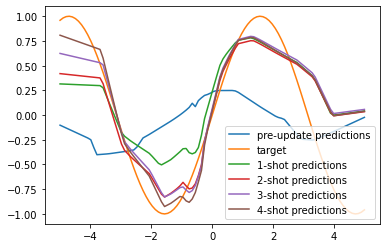

In [121]:
# batch the inference across K=100
x = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(x)
predictions = jax.vmap(functools.partial(mlp.apply, params))(x)
plt.plot(x, predictions, label='pre-update predictions')
plt.plot(x, targets, label='target')

x1 = np.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * np.sin(x1 + 0.)

net_params = params
for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = jax.vmap(functools.partial(mlp.apply, net_params))(x)
    plt.plot(x, predictions, label='{}-shot predictions'.format(i))
plt.legend()

# Autoregressive Flows

In [ ]:
from sklearn.datasets import make_checkerboard, make_moons
from matplotlib import pyplot as plt

X_train, X_test = make_moons(5000, noise=0.07)

fig, ax = plt.subplots()
_ =  ax.hist2d(*X_train.T, bins=100)


In [ ]:
params

In [ ]:
from numpyro.distributions.flows import InverseAutoregressiveTransform
from numpyro.distributions import Normal
import numpyro
from typing import Sequence



def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    return masks

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal(),
)

params, log_pdf, sample = init_fun(flow_rng, input_dim)



class Flow(flax.linen.Module):
    base_dist: numpyro.distributions.Distribution
    transforms: Sequence[flax.nn.Module]
    
    def __call__(self, key, num_samples):
        return self.forward(key, num_samples)

    def forward(self, key, num_samples):
        logdet = jnp.zeros(num_samples)
        x = self.base_dist.sample(key, (1, num_samples,1)).reshape(-1,2)
        for transform in self.transforms:
            x, t_logdet = transform(x)
            logdet+=t_logdet
        return x, self.base_dist.expand(x.shape).log_prob(x).sum(-1)+t_logdet[:]

    def inverse(self, x):
        logdet = jnp.zeros(x.shape[0])
        for transform in reversed(self.transforms):
            x, t_logdet = transform.inverse(x)
            logdet+=t_logdet
        return x, self.base_dist.expand(x.shape).log_prob(x).sum(-1) + t_logdet[:, None]
    

class MADE(flax.linen.Module):
    arnn: flax.nn.Module
    
    def inverse(self, x):
        log_weight, bias = self.arnn(x).split(2, axis=1)
        outputs = (x - bias) * jnp.exp(-log_weight)
        log_det_jacobian = -log_weight.sum(-1)
        return outputs, log_det_jacobian

    def forward(self, x):
        outputs = jnp.zeros_like(x)
        for i_col in range(x.shape[1]):
            log_weight, bias = self.arnn(outputs).split(2, axis=1)
            outputs = jax.ops.index_update(
                outputs, jax.ops.index[:, i_col], x[:, i_col] * jnp.exp(log_weight[:, i_col]) + bias[:, i_col]
            )
        log_det_jacobian = -log_weight.sum(-1)
        return outputs, log_det_jacobian

    def __call__(self, x):
        return self.forward(x)

arnn = MLPCompact(2, 64, 2)
made = MADE(arnn)
flow = Flow(Normal(jnp.zeros(2), jnp.ones(2)), [made])

x = jnp.zeros((10, 2))
key, _ = jax.random.split(key)
params = flow.init(key, key, 10)



In [ ]:
from tqdm.notebook import tqdm
import optax

def arr_iterator(arr, batch_size):
    iters = int(arr.shape[0]/batch_size)
    for i in range(0, iters, batch_size):
        yield arr[i*batch_size:(i+1)*batch_size]

optimizer = optax.adam(1e-3)
def construct_training_step(model, optimizer):
  # model forward
  def model_loss(params, x):
    _, logprob = model.apply(params, x, method=model.inverse)
    return jnp.mean(-logprob) # NLL
  
  grad_func = jax.value_and_grad(model_loss, argnums=0)
  # this is the function that we call in the end
  def update_func(params, opt_state,  x):
    loss, grads = grad_func(params, x)
    updates, opt_state = optimizer.update(grads, opt_state)
    return loss, updates, opt_state

  return jax.jit(update_func)


#params = None
for e in range(100):
  #tqdm_iter = tqdm(arr_iterator(X_train, 128))
  for i, batch in enumerate(arr_iterator(X_train, 128)):

    if params is None:
      # initialize params, optimizer
      rk1, rk2 = jax.random.split(key)
      params = flow.init(rk1, rk2, 10)
      opt_state = optimizer.init(params)
      training_step = construct_training_step(flow, optimizer)

    key, _ = jax.random.split(key)
    loss, updates, opt_state = training_step(params, opt_state, x)
    params = optax.apply_updates(params, updates)
  print(f"Epoch {e:5d}, batch {i:5d}, loss={loss:10.5f}")
    #tqdm_iter.set_description(f"Epoch {e:5d}, batch {i:5d}, loss={loss:10.5f}")

    

In [ ]:
x, logdet  = flow.apply(params, key, 200)
_ = plt.hist2d(*x.T, bins=100)

In [ ]:
base_dist = Normal(jnp.zeros(2),jnp.ones(2))
base_dist.expand(x.shape).log_prob(x)

In [ ]:
x.shapea

In [ ]:
logits, z, mean, logvar = vae.apply(params, key, image)


# Stein Variational Gradient Descent

In [ ]:

class SVGD(flax.linen.Module):
  base_dist: numpyro.distributions.Distribution
  kernel: callable

  def __init__(self, P, K, optimizer):
    self.P = P
    self.K = K
    self.optim = optimizer

  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.base_dist.log_prob(X)
    score_func = autograd.grad(log_prob.sum(), X)[0]

    K_XX = self.K(X, X.detach())
    grad_K = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()